In [2]:
import math
import itertools

import numpy as np
import pandas as pd
import scipy

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
from sklearn import ensemble
from sklearn import pipeline
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics.pairwise import cosine_similarity
import patsy

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
#import statannot
import statannotations
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
#import plotnine as p9

import Bio.motifs as motifs

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import gensim

from gensim.test.utils import common_texts

from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [4]:
class Kmerizer:
    
    def __init__(self, k, log=False, divide=False, leave_one_out=False):
        self.k = k
        if leave_one_out:
            self.kmers = {"".join(x):i for i,x in zip(range(4**k), [x for x in itertools.product("ACGT",repeat=k)][:-1])}
        else:
            self.kmers = {"".join(x):i for i,x in zip(range(4**k), itertools.product("ACGT",repeat=k))}
        self.log = log
        self.divide = divide
        
    def kmerize(self, seq):
        counts = np.zeros(4**self.k)
        i = 0
        while i < len(seq) - self.k + 1: 
            kmer = seq[i:i+self.k]
            counts[self.kmers[kmer]] += 1
            i += 1
        if self.divide:
            counts = counts/len(seq)
        if self.log:
            counts = np.log(counts + 1)
        return counts
    
    def tokenize(self, seq, jump=False):
        kmers = []
        i = 0
        while i < len(seq) - self.k + 1: 
            kmer = seq[i:i+self.k]
            kmers.append(kmer)
            if jump:
                i += self.k
            else:
                i += 1
        return kmers
    
kmerizer1 = Kmerizer(k=1)
kmerizer2 = Kmerizer(k=2)
kmerizer3 = Kmerizer(k=3)
kmerizer4 = Kmerizer(k=4)
kmerizer5 = Kmerizer(k=5)
kmerizer6 = Kmerizer(k=6)
kmerizer7 = Kmerizer(k=7)

In [5]:
def max_repeat_length(seq,k):
    
    '''
    Get repeat lengths of all k-mers in sequence
    '''

    max_subseq_lenght = {"".join(x):0 for x in itertools.product("ACGT",repeat=k)}

    for start in range(k):
        c=1
        for seq_idx in range(start,len(seq)-k+1,k):
            bp = seq[seq_idx:seq_idx+k] #repeated sequence
            if bp==seq[seq_idx+k:seq_idx+2*k]:
                c+=1
            else:
                max_subseq_lenght[bp] = max(max_subseq_lenght[bp],c)
                c = 1
                
        max_subseq_lenght[bp] = max(max_subseq_lenght[bp],c)
       
    repeat_length = np.array(list(max_subseq_lenght.values()))
    
    return repeat_length

In [41]:
def pearson_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    if len(y_pred.shape) == 2:
        y_pred = y_pred.reshape(-1)
    return scipy.stats.pearsonr(y, y_pred)[0]

def pearson_r2(estimator, X, y):
    y_pred = estimator.predict(X)
    #print(estimator[1].alpha_)
    if len(y_pred.shape) == 2:
        y_pred = y_pred.reshape(-1)
    return scipy.stats.pearsonr(y, y_pred)[0] ** 2

def pearson_r2_metric(y_true, y_pred):
    return scipy.stats.pearsonr(y_true, y_pred)[0] ** 2

def bootstrap_normal(x, y):
    x, y = np.array(x), np.array(y)
    z_val = np.abs(((x - y).mean())/((x - y).std()))
    return z_val, (1 - scipy.stats.norm.cdf(z_val) + scipy.stats.norm.cdf(-z_val))

custom_long_name = 'Bootstrap Normal'
custom_short_name = 'Normal'
custom_func = bootstrap_normal
bstrap_normal_test = StatTest(custom_func, custom_long_name, custom_short_name)

def bootstrap_empirical(x, y):
    x, y = np.array(x), np.array(y)
    diffs = (x - y)
    stat = np.sum(diffs < 0) 
    p = (stat + 1)/(len(x) + 1)
    #if np.median(diffs) > 0:
    #    stat = np.sum(diffs < 0) 
    #    p = 2*(stat + 1)/(len(x) + 1)
    #else:
    #    stat = np.sum(diffs > 0) 
    #    p = 2*(stat + 1)/(len(x) + 1)
    return stat, p

custom_long_name = 'Bootstrap Empirical'
custom_short_name = 'Empirical'
custom_func = bootstrap_empirical
bstrap_empirical_test = StatTest(custom_func, custom_long_name, custom_short_name)

In [106]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/griesemer/'

expression_df = pd.read_csv(data_dir + 'paper_supplementary/Variant_MPRAu_Results.txt', sep='\t')
oligo_info_df = pd.read_csv(data_dir + 'paper_supplementary/Oligo_Variant_Info.txt', sep='\t')

In [107]:
fasta_fa = data_dir + 'fasta/GRCh38_UTR_variants.fa'

seq = {}

with open(fasta_fa, 'r') as f:
    for line in f:
        if line.startswith('>'):
            oligo_id = line[1:].replace(':Homo_sapiens\n','')
            seq[oligo_id] = ''
        else:
            seq[oligo_id] += line.rstrip()

mpra_df = pd.DataFrame(seq.items(), columns=['oligo_id', 'seq'])

In [108]:
utr_variants = pd.read_csv(data_dir + '/GRCh38_UTR_variants.tsv', sep='\t')

In [109]:
utr_variants['stop_codon_dist'] = utr_variants.apply(lambda x: x.var_start-x.human_UTR_start if x.strand=='+' else
                  x.human_UTR_end - x.var_start, axis=1)

In [110]:
mpra_df['min_free_energy'] = pd.read_csv(data_dir + 
                                         'fasta/GRCh38_UTR_variants.free_energy.tsv', header=None).squeeze()

In [111]:
mpra_df = mpra_df.merge(oligo_info_df[['oligo_id','mpra_variant_id','ref_allele','alt_allele', 'gene_symbols','chrom', 'oligo_starts', 'oligo_ends']]).merge(expression_df).merge(utr_variants[['mpra_variant_id','stop_codon_dist']].drop_duplicates())

mpra_df.columns

Index(['oligo_id', 'seq', 'min_free_energy', 'mpra_variant_id', 'ref_allele',
       'alt_allele', 'gene_symbols', 'chrom', 'oligo_starts', 'oligo_ends',
       'log2FoldChange_Skew_HEK293FT', 'lfcSE_Skew_HEK293FT',
       'pvalue_Skew_HEK293FT', 'padj_Skew_HEK293FT',
       'log2FoldChange_Ref_HEK293FT', 'lfcSE_Ref_HEK293FT',
       'pvalue_Ref_HEK293FT', 'padj_Ref_HEK293FT',
       'log2FoldChange_Alt_HEK293FT', 'lfcSE_Alt_HEK293FT',
       'pvalue_Alt_HEK293FT', 'padj_Alt_HEK293FT', 'log2FoldChange_Skew_HEPG2',
       'lfcSE_Skew_HEPG2', 'pvalue_Skew_HEPG2', 'padj_Skew_HEPG2',
       'log2FoldChange_Ref_HEPG2', 'lfcSE_Ref_HEPG2', 'pvalue_Ref_HEPG2',
       'padj_Ref_HEPG2', 'log2FoldChange_Alt_HEPG2', 'lfcSE_Alt_HEPG2',
       'pvalue_Alt_HEPG2', 'padj_Alt_HEPG2', 'log2FoldChange_Skew_HMEC',
       'lfcSE_Skew_HMEC', 'pvalue_Skew_HMEC', 'padj_Skew_HMEC',
       'log2FoldChange_Ref_HMEC', 'lfcSE_Ref_HMEC', 'pvalue_Ref_HMEC',
       'padj_Ref_HMEC', 'log2FoldChange_Alt_HMEC', 'lfcSE_A

In [112]:
mpra_df['group'] = mpra_df['gene_symbols']

In [113]:
df = mpra_df.sort_values(by=['chrom','oligo_starts','oligo_ends']).drop_duplicates(subset=['mpra_variant_id']).reset_index(drop=True)

df['other_mpra_variant_id'] = ''

for row_idx in range(len(df)-1):
    next_row_idx = row_idx+1
    while df.loc[row_idx].chrom==df.loc[next_row_idx].chrom and df.loc[next_row_idx].oligo_starts<df.loc[row_idx].oligo_ends:
        if df.loc[row_idx].gene_symbols != df.loc[next_row_idx].gene_symbols:
            df.loc[row_idx,'other_mpra_variant_id'] += df.loc[next_row_idx,'mpra_variant_id'] + ','
        next_row_idx+=1
        
df = df.loc[df.other_mpra_variant_id!='',['mpra_variant_id','other_mpra_variant_id']]  

for mpra_variant_id, other_mpra_variant_ids in df.values.tolist():
    for other_mpra_variant_id in other_mpra_variant_ids.rstrip(',').split(','):
        mpra_df.loc[mpra_df.mpra_variant_id==other_mpra_variant_id,'group'] = mpra_df.loc[mpra_df.mpra_variant_id==mpra_variant_id,'group'].iloc[0]

In [114]:
emb_mpra = np.load(data_dir + "embeddings/seq_len_5000/embeddings.npy")

In [115]:
cell_type = 'GM12878' #HMEC,HEK293FT,HEPG2,K562,GM12878,SKNSH

In [139]:
predict_skew = True

In [140]:
is_snp = mpra_df.ref_allele.str.len() == mpra_df.alt_allele.str.len()

flt = mpra_df[f'log2FoldChange_Skew_{cell_type}'].isna()  | (~is_snp) | (mpra_df.stop_codon_dist>5000) #| mpra_df.oligo_id.str.contains('_ref$')

mpra_df = mpra_df[~flt]

In [141]:
if predict_skew:
    mpra_df['Expression'] = mpra_df[f'log2FoldChange_Skew_{cell_type}']
    mpra_df['seqtype'] = mpra_df.apply(lambda x: 'REF' if x.oligo_id.endswith('_ref') else 'ALT',axis=1)
    assert (mpra_df.loc[mpra_df.seqtype=='REF','mpra_variant_id'].values==\
         mpra_df.loc[mpra_df.seqtype=='ALT','mpra_variant_id'].values).mean()==1
else:
    mpra_df['Expression'] = mpra_df.apply(lambda x: x[f'log2FoldChange_Alt_{cell_type}'] if x.oligo_id.endswith('_alt') else x[f'log2FoldChange_Ref_{cell_type}'], axis=1)   

In [142]:
mpra_df.Expression = mpra_df.Expression.apply(lambda x:x.replace(',','.') if type(x)==str else x).astype(float)

In [143]:
def minseq_model(mpra_df):

    nucl_counts = np.stack(mpra_df.seq.apply(lambda seq: kmerizer1.kmerize(seq)))
    max_nucl_counts_all = nucl_counts.max(axis=1)

    dinucl_counts = np.stack(mpra_df.seq.apply(lambda seq: kmerizer2.kmerize(seq)))
    max_dinucl_counts_all = dinucl_counts.max(axis=1)
    
    max_homopol_len = np.stack(mpra_df.seq.apply(lambda seq: max_repeat_length(seq,1)))
    max_dinucl_len = np.stack(mpra_df.seq.apply(lambda seq: max_repeat_length(seq,2)))

    seq_uniformity = mpra_df.seq.apply(lambda seq: np.sum([seq[i]==seq[i-1] for i in range(1,len(seq))])).values
    min_free_energy = mpra_df['min_free_energy'].values
    
    X = np.hstack((nucl_counts,np.expand_dims(max_nucl_counts_all,axis=1),
           dinucl_counts,np.expand_dims(max_dinucl_counts_all,axis=1),
           max_homopol_len, max_dinucl_len,
           np.expand_dims(seq_uniformity,axis=1),
           np.expand_dims(min_free_energy,axis=1),
           ))
    
    return X

def word2vec_model(mpra_df):
    
    kmerizer_w2v = Kmerizer(k=4)
    w2v_model = Word2Vec(sentences=mpra_df.seq.apply(lambda x: kmerizer_w2v.tokenize(x, jump=False)), 
                         vector_size=128, window=5, min_count=1, workers=4, sg=1)

    word2vec_emb = mpra_df.seq.apply(
        lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x, jump=False)],axis=0))

    X = np.stack(word2vec_emb,axis=0)#np.stack(doc2vec_emb,axis=0)
    
    return X

In [144]:
def get_embeddings(mpra_df):

    X_emb = emb_mpra[mpra_df.index]

    #GC_content_UTR3 = (mpra_df.seq.str.count('G') + mpra_df.seq.str.count('C'))/mpra_df.seq.str.len()
    #X_gc = np.expand_dims(GC_content_UTR3.values,axis=1)

    #X_2mer = np.stack(mpra_df.seq.apply(lambda x: kmerizer2.kmerize(x)))
    #X_3mer = np.stack(mpra_df.seq.apply(lambda x: kmerizer3.kmerize(x)))
    X_4mer = np.stack(mpra_df.seq.apply(lambda x: kmerizer4.kmerize(x)))
    #X_5mer = np.stack(mpra_df.seq.apply(lambda x: kmerizer5.kmerize(x)))
    #X_6mer = np.stack(mpra_df.seq.apply(lambda x: kmerizer6.kmerize(x)))

    X_minseq = minseq_model(mpra_df)
    X_w2v = word2vec_model(mpra_df)
    
    min_free_energy = mpra_df['min_free_energy'].values
    
    X_emb = np.hstack((X_emb,np.expand_dims(min_free_energy,axis=1)))
    X_4mer = np.hstack((X_4mer,np.expand_dims(min_free_energy,axis=1)))
    X_w2v = np.hstack((X_w2v,np.expand_dims(min_free_energy,axis=1)))

    data_matrices = {"MLM":X_emb,
                 "4-mer counts":X_4mer,
                 "Word2Vec": X_w2v,
                 "Griesemer et al.": X_minseq,
                }
    
    y = mpra_df['Expression'].values

    groups = mpra_df['group'].values
    
    return data_matrices, y, groups

In [145]:
if predict_skew:
    data_matrices_ref, _, _ = get_embeddings(mpra_df[mpra_df.seqtype=='REF'])
    data_matrices_alt, y, groups = get_embeddings(mpra_df[mpra_df.seqtype=='ALT'])
    data_matrices = {model:np.hstack((data_matrices_ref[model],data_matrices_alt[model])) for model in data_matrices_ref}
else:
    data_matrices, y, groups = get_embeddings(mpra_df)
    

In [146]:
#y = (y<-0.5).astype(int)

In [147]:
from IPython.display import clear_output

metrics_mpra = []

for model,X in data_matrices.items():
    print(model)
    #pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=3,alphas=10.**np.arange(-10,10))) #limit runtime
    #pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.LogisticRegressionCV(max_iter=500,class_weight='balanced',scoring='roc_auc')) #limit runtime
    pipe = sklearn.ensemble.RandomForestRegressor(n_estimators=1000,min_samples_split=10,n_jobs=-1)
    #pipe = sklearn.ensemble.GradientBoostingRegressor(n_estimators=300)
    #pipe = sklearn.ensemble.GradientBoostingClassifier()

    #pipe = sklearn.ensemble.RandomForestClassifier(class_weight='balanced')
    #rmse = -cross_val_score(pipe,X,y,scoring="neg_root_mean_squared_error",cv=sklearn.model_selection.GroupKFold(n_splits=10), groups=groups)#.mean()
    r2 = cross_val_score(pipe,X,y,scoring=pearson_r2,cv=sklearn.model_selection.GroupKFold(n_splits=10), groups=groups, n_jobs=-1)#.mean()
    for r2_val in r2:
        metrics_mpra.append({"model":model, "score":r2_val})

metrics_mpra = pd.DataFrame(metrics_mpra)

clear_output()

In [148]:
metrics_mpra.groupby('model').mean()

,score
model,
4-mer counts,0.012022
Griesemer et al.,0.016685
MLM,0.026276
Word2Vec,0.018535


In [149]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16})

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MLM vs. 4-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.711e-02 (ns) Stat=7.000e+00
MLM vs. Word2Vec: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.934e-01 Stat=1.400e+01
MLM vs. Griesemer et al.: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.309e-01 Stat=1.200e+01


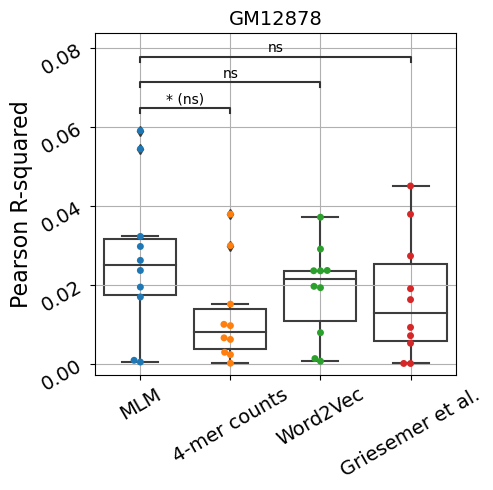

In [150]:
statplot_df = metrics_mpra

x = "model"
y = "score"
y_lab = "Pearson R-squared"

box_pairs=[
    ("MLM", "4-mer counts"),
    ("MLM", "Word2Vec"),
    ("MLM", "Griesemer et al."),
    ]

fig, ax = plt.subplots(figsize=(5,5), dpi=100)

ax = sns.swarmplot(data=statplot_df, x=x, y=y)
ax = sns.boxplot(data=statplot_df, x=x, y=y, boxprops={'facecolor':'None'})

annotator = Annotator(ax, box_pairs, data=statplot_df, x=x, y=y)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel(y_lab)
ax.tick_params(rotation=30)
ax.set_title(cell_type)
ax.grid()

plt.tight_layout()


#fig.savefig("../../../../Plots/Downstream_mpra.svg") 